In [ ]:
# https://zhuanlan.zhihu.com/p/692810462 RF
# https://zhuanlan.zhihu.com/p/692505141 SVM

# https://zhuanlan.zhihu.com/p/112009086 Xboost

In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
expr = readRDS('./expr.rds')

In [3]:
rownames(expr)  = expr[,1]

In [4]:
expr1 = expr[,-c(1,2)]

In [5]:
table(expr$Group)


CON MDD 
 29  30 

In [6]:
head(expr,3)

,Symbol,Group,RPE65,DRD3,MC3R,GPR157,RELB,NFIL3,NMS,PRF1,...,CASP1,IL6,EGR1,PRKG2,NAMPT,PRKAA1,NRIP1,ATF4,ID2,NTRK3
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,V1,CON,3.694608,0,1.31814,0.000000,4.548540,6.428383,0,2.801941,...,4.548540,1.318140,8.876338,8.153575,9.757731,9.263987,10.785255,10.194585,10.033292,12.36519
V10,V10,MDD,2.381054,0,0.00000,2.381054,3.526436,6.003098,0,0.000000,...,6.672710,1.634401,4.929043,6.049678,9.215517,9.637592,9.849888,9.614537,9.337863,10.11376
V11,V11,CON,4.295561,0,0.00000,1.735402,4.295561,7.012734,0,0.000000,...,4.295561,0.000000,8.902656,7.870194,9.392232,9.141579,10.476201,10.373532,9.787846,12.15638


In [7]:
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [8]:
expr %>% filter(Group == 'CON') %>% rownames(.) -> control
expr %>% filter(Group == 'MDD') %>% rownames(.) -> MDD

In [9]:
expr2 = expr1[c(control,MDD),]

In [10]:
dim(expr2)

[1] 59 19

In [11]:
head(expr2,2)

,RPE65,DRD3,MC3R,GPR157,RELB,NFIL3,NMS,PRF1,MAGEL2,CASP1,IL6,EGR1,PRKG2,NAMPT,PRKAA1,NRIP1,ATF4,ID2,NTRK3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,3.694608,0,1.31814,0.000000,4.548540,6.428383,0,2.801941,0,4.548540,1.31814,8.876338,8.153575,9.757731,9.263987,10.78525,10.19459,10.033292,12.36519
V11,4.295561,0,0.00000,1.735402,4.295561,7.012734,0,0.000000,0,4.295561,0.00000,8.902656,7.870194,9.392232,9.141579,10.47620,10.37353,9.787846,12.15638


In [12]:
Type = c(rep(1,length(control)),rep(2,length(MDD)))

In [13]:
x = as.matrix(expr2)

y = Type


In [14]:
library(randomForest)

Warning message:
"package 'randomForest' was built under R version 4.2.3"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine




In [15]:
set.seed(111)

In [16]:
rf = randomForest(as.factor(y)~.,data = x,ntree =1000,important=TRUE,proximity=TRUE)

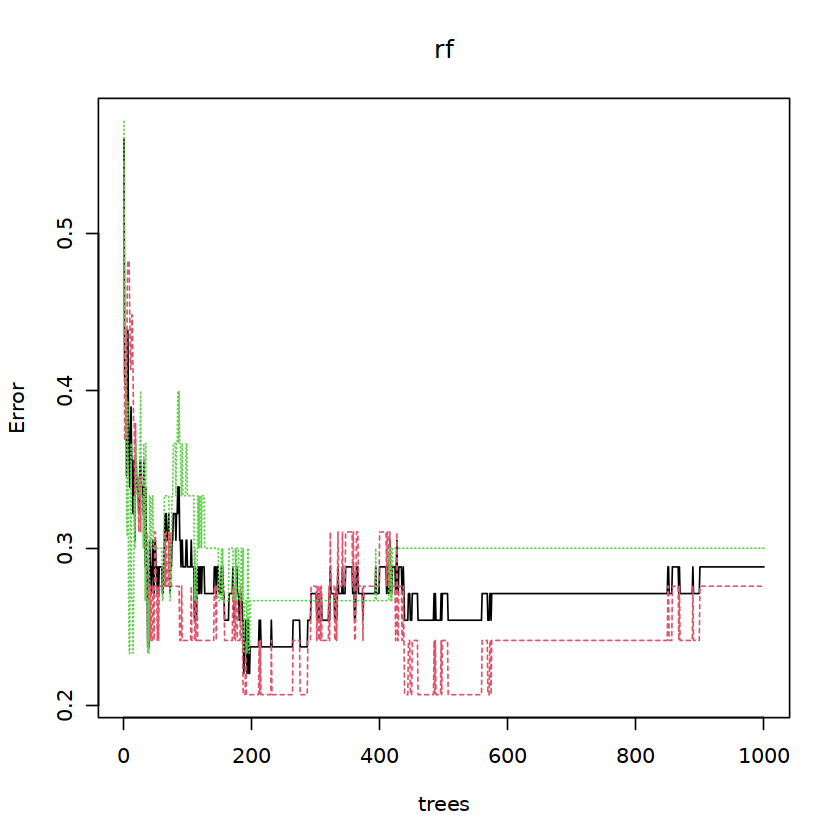

In [17]:
plot(rf)

In [18]:
pdf('forest.pdf',height = 6,width = 6)
plot(rf)
dev.off()

png 
  2

In [19]:
trees = which.min(rf$err.rate[,1])

In [20]:
rf = randomForest(as.factor(y)~.,data = x,ntree =trees,important=TRUE,proximity=TRUE)

In [21]:
importance = importance(rf)

In [22]:
pdf('forest2.pdf',height = 6,width = 6)
varImpPlot(rf,main = '')
dev.off()

png 
  2

In [ ]:
# RPE65 + MC3R+NFIL3 + PRF1 + IL6

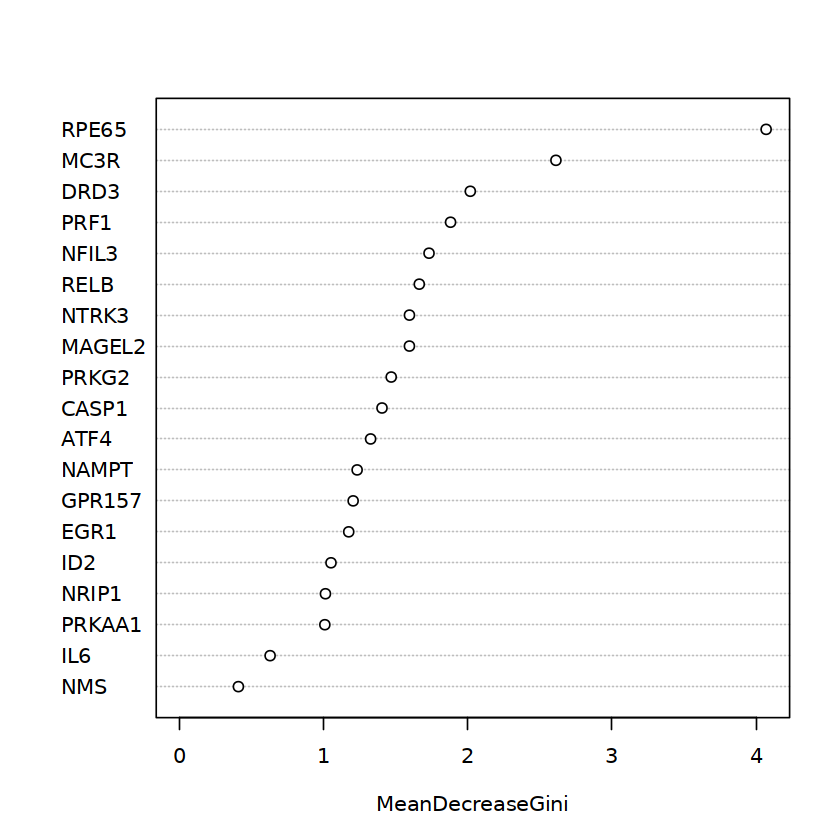

In [23]:
varImpPlot(rf,main = '')

In [24]:
rfGenes=importance[order(importance[, "MeanDecreaseGini"], decreasing  = TRUE),] #重要性评分大于2的基因

In [25]:
rfGenes

RPE65      MC3R      DRD3      PRF1     NFIL3      RELB     NTRK3    MAGEL2 
4.0699700 2.6110251 2.0168771 1.8798963 1.7303996 1.6627207 1.5945024 1.5943037 
    PRKG2     CASP1      ATF4     NAMPT    GPR157      EGR1       ID2     NRIP1 
1.4679751 1.4041149 1.3250435 1.2314093 1.2037489 1.1730515 1.0500688 1.0115373 
   PRKAA1       IL6       NMS 
1.0072889 0.6275688 0.4073766

In [26]:
rfGenes=names(rfGenes[rfGenes>30]) 
write.table(rfGenes,file="rfGenes.txt",sep="\t",quote=F,col.names=F,row.names=F) #输出表达量

In [27]:
sigExp=expr2[rfGenes,]
write.table(data.frame(ID=rownames(sigExp),sigExp),file="rfGeneExp.txt",sep="\t",quote=F,col.names=T,row.names=F) 

### svm

In [28]:
library(tidyverse)
library(glmnet)
library(VennDiagram)
library(e1071)
library(caret)
library(randomForest)

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.3     v purrr   1.0.1
v tibble  3.2.1     v stringr 1.5.0
v tidyr   1.3.0     v forcats 1.0.0
v readr   2.1.4     
Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x randomForest::combine() masks dplyr::combine()
x dplyr::filter()         masks stats::filter()
x dplyr::lag()            masks st

In [29]:
y=as.numeric(as.factor(Type))

In [30]:
library(future)
plan("multisession",workers=30)

Warning message:
"package 'future' was built under R version 4.2.3"

Attaching package: 'future'


The following object is masked from 'package:caret':

    cluster




In [31]:
set.seed(1)
rfeControl = rfeControl(functions = caretFuncs,
                        method = "cv", # 默认自助法重采样 boot
                        saveDetails = T, # 保存预测值和变量重要性
                        number = 5, # 重抽样次数
                        allowParallel = T # 允许多线程，用这个之前你要先准备好多线程！
                        )

In [32]:
Profile=rfe(x=x,y=y,sizes = c(1:10),
    rfeControl =  rfeControl,
    methods="svmRadial")

Warning message in train.default(x, y, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

In [33]:
pdf(file="SVM-RFE.pdf", width=6, height=5.5)
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)
dev.off()

png 
  2

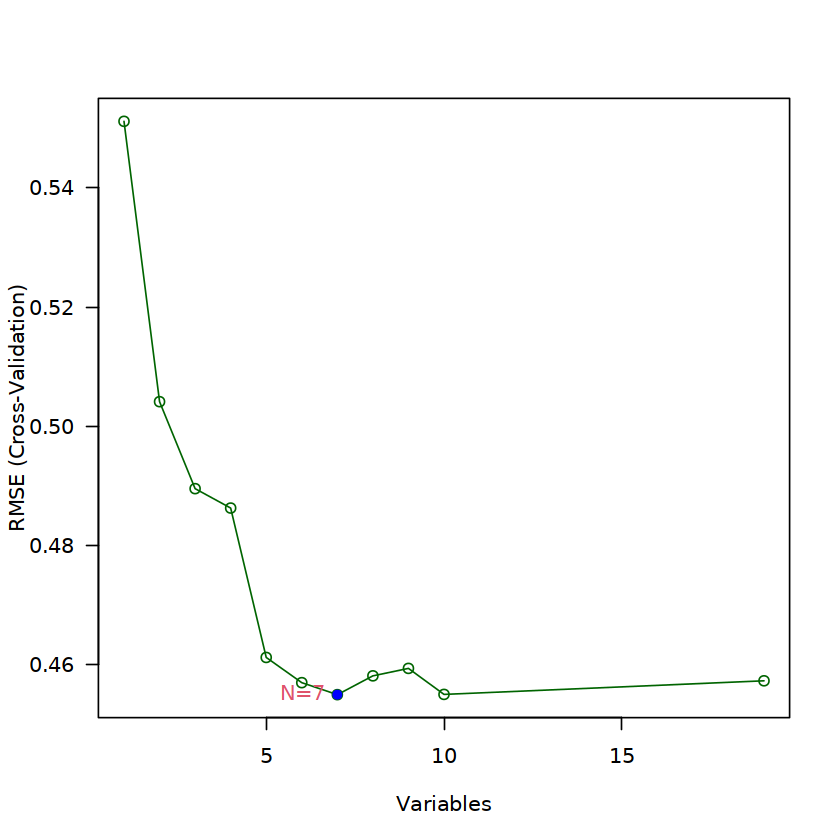

In [34]:
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)

In [35]:
#输出
featureGenes = Profile$optVariables
write.table(file="SVM-RFE.gene.txt",featureGenes,sep="\t",quote=F,row.names=F,col.names=F) #表达矩阵 

In [46]:
featureGenes

[1] "RPE65" "MC3R"  "DRD3"  "NFIL3" "PRF1"  "NTRK3" "RELB"

In [ ]:
#RPE65 + MC3R+NFIL3 + PRF1 + IL6

### Boruta

In [36]:
library(Boruta)

In [37]:
x = as.matrix(expr2)
y = Type

In [38]:
set.seed(1)
boruta <- Boruta(x=x, y=y, pValue=0.05, mcAdj=T, 
       maxRuns=300)

In [39]:
boruta

Boruta performed 299 iterations in 13.73555 secs.
 6 attributes confirmed important: DRD3, MAGEL2, MC3R, NTRK3, RELB and
1 more;
 11 attributes confirmed unimportant: CASP1, EGR1, GPR157, ID2, IL6 and
6 more;
 2 tentative attributes left: ATF4, PRF1;

In [40]:
table(boruta$finalDecision)


Tentative Confirmed  Rejected 
        2         6        11 

In [41]:
boruta$finalDecision

RPE65      DRD3      MC3R    GPR157      RELB     NFIL3       NMS      PRF1 
Confirmed Confirmed Confirmed  Rejected Confirmed  Rejected  Rejected Tentative 
   MAGEL2     CASP1       IL6      EGR1     PRKG2     NAMPT    PRKAA1     NRIP1 
Confirmed  Rejected  Rejected  Rejected  Rejected  Rejected  Rejected  Rejected 
     ATF4       ID2     NTRK3 
Tentative  Rejected Confirmed 
Levels: Tentative Confirmed Rejected

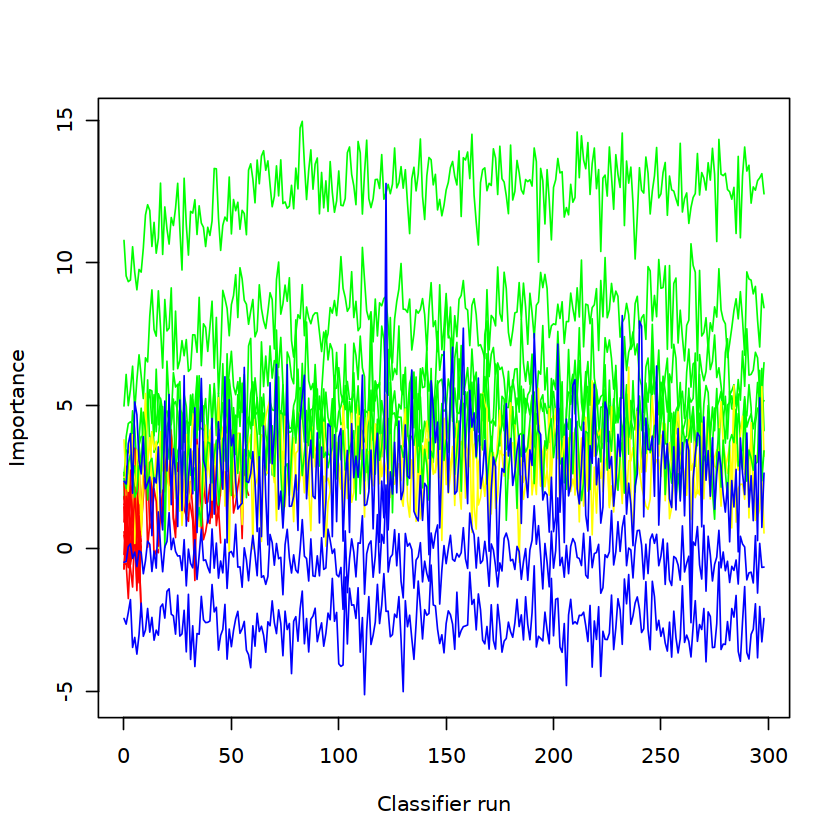

In [42]:
Boruta::plotImpHistory(boruta)

In [43]:
library(dplyr)
boruta.imp <- function(x){
  imp <- reshape2::melt(x$ImpHistory, na.rm=T)[,-1]
  colnames(imp) <- c("Variable","Importance")
  imp <- imp[is.finite(imp$Importance),]

  variableGrp <- data.frame(Variable=names(x$finalDecision), 
                            finalDecision=x$finalDecision)

  showGrp <- data.frame(Variable=c("shadowMax", "shadowMean", "shadowMin"),
                        finalDecision=c("shadowMax", "shadowMean", "shadowMin"))

  variableGrp <- rbind(variableGrp, showGrp)

  boruta.variable.imp <- merge(imp, variableGrp, all.x=T)

  sortedVariable <- boruta.variable.imp %>% group_by(Variable) %>% 
    summarise(median=median(Importance)) %>% arrange(median)
  sortedVariable <- as.vector(sortedVariable$Variable)


  boruta.variable.imp$Variable <- factor(boruta.variable.imp$Variable, levels=sortedVariable)

  invisible(boruta.variable.imp)
}
boruta.variable.imp <- boruta.imp(boruta)


In [44]:
boruta

Boruta performed 299 iterations in 13.73555 secs.
 6 attributes confirmed important: DRD3, MAGEL2, MC3R, NTRK3, RELB and
1 more;
 11 attributes confirmed unimportant: CASP1, EGR1, GPR157, ID2, IL6 and
6 more;
 2 tentative attributes left: ATF4, PRF1;

Welcome to YSX package which is a collection of useful scripts.
This package does not require you install all depended packages, since one may not need all functions in this package.
However, when there is a message implying some functions are missing,please install these packages manually.
Or more specially, check Plot.Rmd in vignettes first.




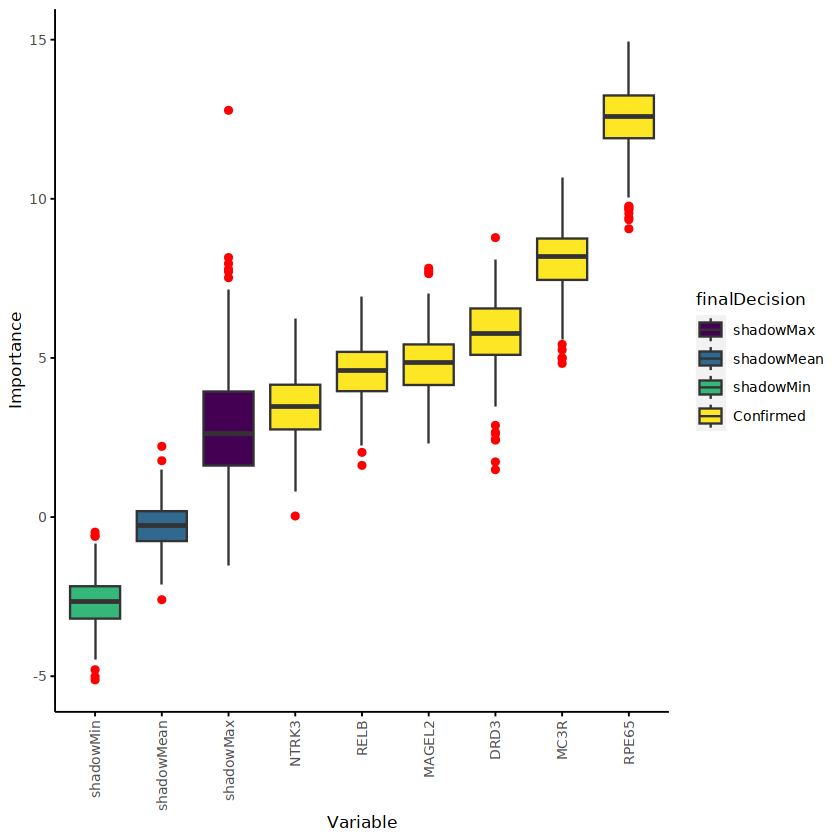

In [45]:
library(YSX)

sp_boxplot(boruta.variable.imp, melted=T, xvariable = "Variable", yvariable = "Importance",
           legend_variable = "finalDecision", legend_variable_order = c("shadowMax", "shadowMean", "shadowMin", "Confirmed"),
           xtics_angle = 90)

In [47]:
expr3 = expr[,-1]

In [48]:
set.seed(147)  
index <-  which( (1:nrow(expr3))%%3 == 0 )
train <- expr3[-index,]
test <- expr3[index,]

In [66]:
table(test$Group)


CON MDD 
 13   6 

In [53]:
library("xgboost")
library("Matrix")
train_matrix <- sparse.model.matrix(Group ~ .-1, data = train)
test_matrix <- sparse.model.matrix(Group ~ .-1, data = test)
all_matrix <- sparse.model.matrix(Group ~ .-1, data = expr3)

In [54]:
train_label <- as.numeric(train$Group == 'MDD')
test_label <-  as.numeric(test$Group == 'MDD')
all_label <-  as.numeric(expr3$Group == 'MDD')

In [55]:
all_label

[1] 0 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0
[39] 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0

In [56]:
train_fin <- list(data=train_matrix,label=train_label) 
test_fin <- list(data=test_matrix,label=test_label) 
all_fin <- list(data=all_matrix,label=all_label) 

dtrain <- xgb.DMatrix(data = train_fin$data, label = train_fin$label) 
dtest <- xgb.DMatrix(data = test_fin$data, label = test_fin$label)
dall <- xgb.DMatrix(data = all_fin$data, label = all_fin$label)

In [57]:
xgb <- xgboost(data = dall,max_depth=6, eta=0.5,  
  objective='binary:logistic', nround=25)

[1]	train-logloss:0.478091 
[2]	train-logloss:0.352804 
[3]	train-logloss:0.258811 
[4]	train-logloss:0.211613 
[5]	train-logloss:0.172575 
[6]	train-logloss:0.146544 
[7]	train-logloss:0.129008 
[8]	train-logloss:0.115318 
[9]	train-logloss:0.104847 
[10]	train-logloss:0.097022 
[11]	train-logloss:0.088329 
[12]	train-logloss:0.082849 
[13]	train-logloss:0.078132 
[14]	train-logloss:0.075979 
[15]	train-logloss:0.071095 
[16]	train-logloss:0.067425 
[17]	train-logloss:0.066081 
[18]	train-logloss:0.064840 
[19]	train-logloss:0.063535 
[20]	train-logloss:0.061872 
[21]	train-logloss:0.060941 
[22]	train-logloss:0.060025 
[23]	train-logloss:0.058967 
[24]	train-logloss:0.058081 
[25]	train-logloss:0.057269 


In [58]:
xgb

##### xgb.Booster
raw: 24.9 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max_depth = 6, eta = 0.5, objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "6", eta = "0.5", objective = "binary:logistic", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 19 
niter: 25
nfeatures : 19 
evaluation_log:
    iter train_logloss
       1    0.47809129
       2    0.35280428
---                   
      24    0.05808055
      25    0.05726944

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
RPE65,0.33864590,0.22560071,0.1833333
MC3R,0.17055998,0.13723158,0.1000000
DRD3,0.14845647,0.18209376,0.1833333
PRF1,0.06880924,0.11357960,0.1500000
NFIL3,0.06226312,0.11330105,0.1500000
MAGEL2,0.05993992,0.05571085,0.0500000


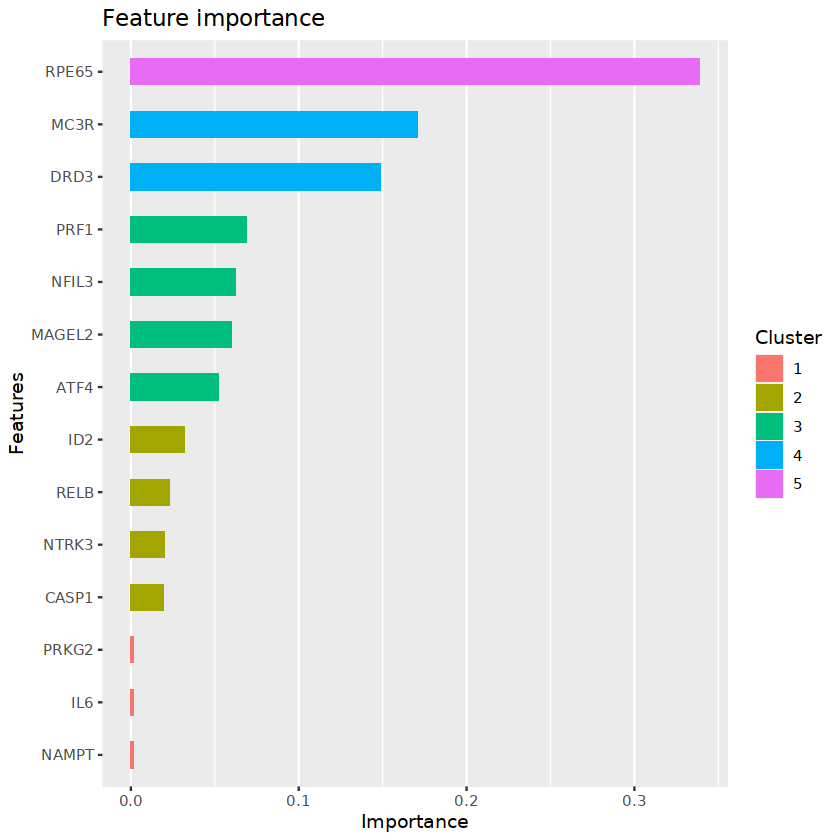

In [59]:
importance <- xgb.importance(all_matrix@Dimnames[[2]], model = xgb)  
head(importance)
xgb.ggplot.importance(importance)

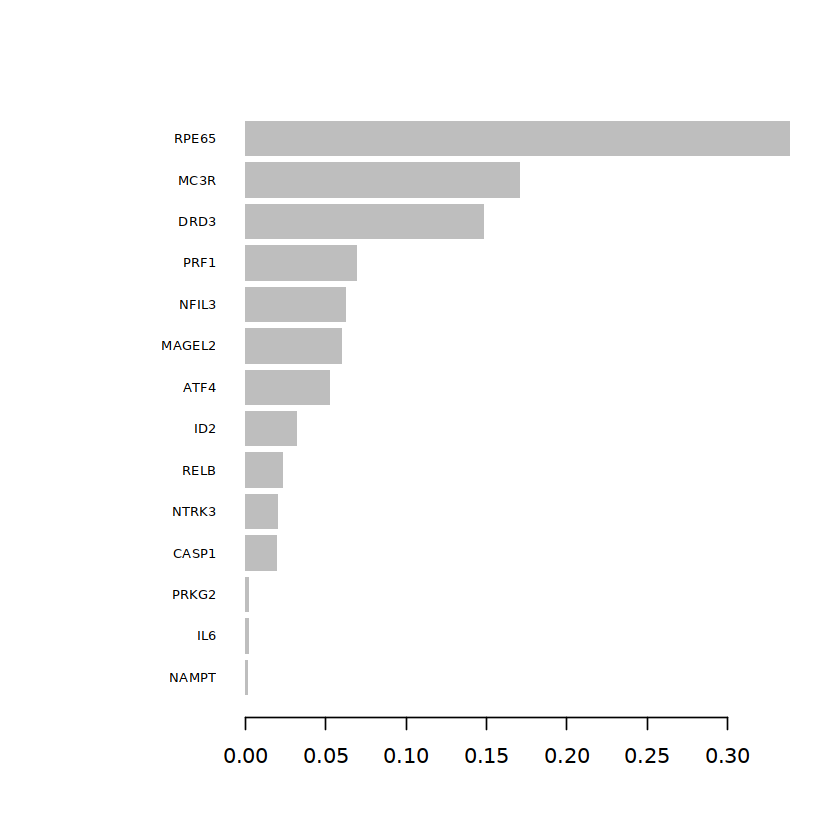

In [60]:
xgb.plot.importance(importance)

### 韦恩图

In [136]:
Boruta.gene

[1] "DRD3"   "MAGEL2" "MC3R"   "NTRK3"  "RELB"   "RPE65"

In [139]:
RF.gene = colnames(sigExp)
SVF.RFE.gene = featureGenes
XGBoost.gene = importance$Feature

In [146]:
boruta.variable.imp2 = boruta.variable.imp %>% dplyr::filter(finalDecision %in% c('Confirmed','Tentative')) %>% dplyr::select(Variable) %>% unique()

In [147]:
Boruta.gene = as.vector(boruta.variable.imp2$Variable)

In [148]:
list1 = list(RF.gene,SVF.RFE.gene,Boruta.gene,XGBoost.gene)

In [149]:
data =  as.data.frame (do.call (cbind, list1))

Warning message in (function (..., deparse.level = 1) :
"number of rows of result is not a multiple of vector length (arg 2)"


In [150]:

library(venn)
        library(VennDiagram)
        color=c( "#3C5488B2","#00A087B2", 
             "#F39B7FB2","#91D1C2B2", 
             "#8491B4B2", "#DC0000B2", 
             "#7E6148B2","yellow", 
             "darkolivegreen1", "lightskyblue", 
             "darkgreen", "deeppink", "khaki2", 
             "firebrick", "brown1", "darkorange1", 
             "cyan1", "royalblue4", "darksalmon", 
             "darkgoldenrod1", "darkseagreen", "darkorchid")

    if (ncol(data) == 2){
        sample_list <- list(c1 = data[,1], c2 = data[,2])
    }else if(ncol(data) == 3){
        sample_list <- list(RF.gene = data[,1], Boruta.gene = data[,2], XGBoost.gene = data[,3])
    }else if(ncol(data) == 4){
        sample_list <- list(RF.gene = data[,1], SVF.RFE.gene = data[,2], Boruta.gene = data[,3], XGBoost.gene = data[,4])
    }else{
        sample_list <- list(c1 = data[,1], c2 = data[,2], c3 = data[,3], c4 = data[,4], c5 = data[,5])
    }
    
    q <- venn.diagram(sample_list,filename = NULL,
             fill = color[1:(length(sample_list))],
             alpha = 0.50, cat.col = rep('black', ncol(data)), 
             col = 'black', cex = 1, fontfamily = 'serif', cat.cex = 1, cat.fontfamily = 'serif', margin = 0.2
                             )
    pdf(paste0('./',"venn.pdf"))
    grid.draw(q)
    dev.off()

png 
  2

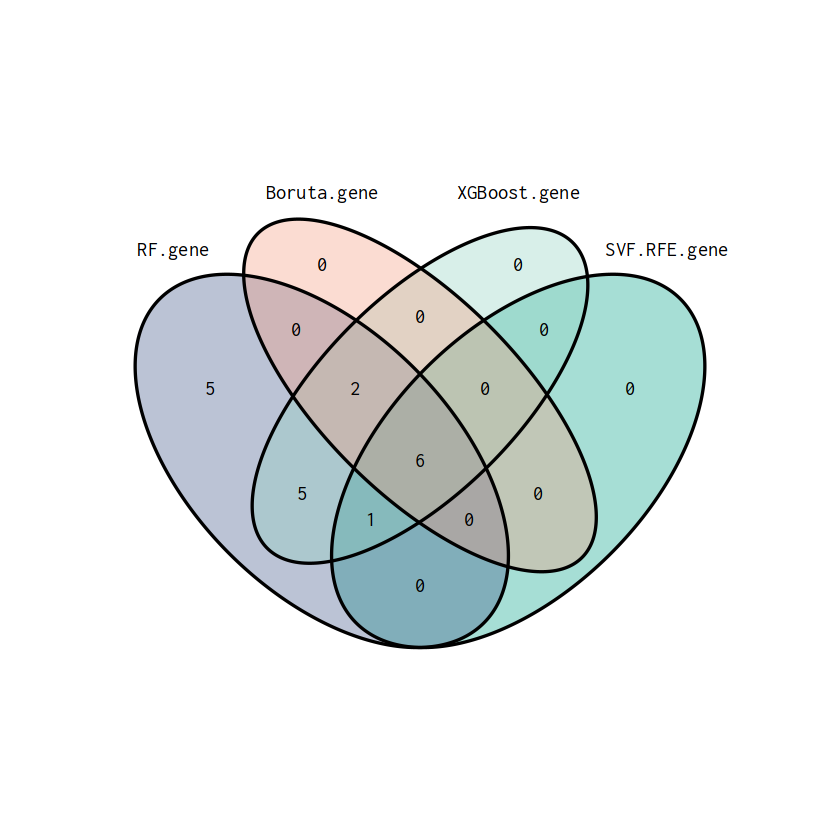

In [151]:
grid.draw(q)

In [152]:
model.gene = intersect(intersect(intersect(RF.gene,XGBoost.gene),Boruta.gene),SVF.RFE.gene)

In [153]:
model.gene

[1] "RPE65" "DRD3"  "MC3R"  "RELB"  "PRF1"  "NTRK3"

In [154]:
set.seed(1234)

In [100]:
#expr3[expr3$Group =='MDD',]$Group<-1

In [101]:

#expr3[expr3$Group =='CON',]$Group<-0
#expr3$Group = as.numeric(expr3$Group)

In [155]:
expr4 = expr3 %>% dplyr::select(c(Group,model.gene))

In [156]:
dim(expr4)

[1] 59  7

In [157]:
head(expr4,4)

,Group,RPE65,DRD3,MC3R,RELB,PRF1,NTRK3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,0,3.694608,0,1.318140,4.548540,2.801941,12.36519
V10,1,2.381054,0,0.000000,3.526436,0.000000,10.11376
V11,0,4.295561,0,0.000000,4.295561,0.000000,12.15638
V12,0,4.934257,0,1.571256,4.934257,2.789708,12.40487


In [158]:
library(caret)
library(ggplot2)

In [159]:
for (i in model.gene){
    res<-pROC::roc(Group~expr4[,i],data=expr4,aur=TRUE,
         ci=TRUE, # 显示95%CI
         #percent=TRUE, # 是否需要以百分比显示
         smooth=FALSE,# 是否平滑曲线
         levels=c(0,1),direction=">" #设置分组方向
         )

p = pROC::ggroc(res, color ="red",legacy.axes = TRUE)+
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), color="darkgrey", linetype=4)+
  theme_bw() + # 设置背景
  ggtitle(paste0(i," ROC Curve"))+
  theme(plot.title = element_text(hjust = 0.5,size = 16),
        axis.text=element_text(size=12,colour = "black"),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14))
p+annotate("text",x=0.75,y=0.25,label=paste("AUC = ", round(res$auc,3)))+
  annotate("text",x=0.75,y=0.20,label=paste("95%CI: ", round(res$ci[1],3),'-',round(res$ci[3],3)))
    ggsave(file = paste0(i,'.ROC.pdf'))
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


### 批量单因素逻辑回归

In [123]:
#expr4 = expr3

In [160]:
#结果合并需要的包
library(plyr)
#可进行logistic回归的包
library(rms)#可实现逻辑回归模型（lrm）
library(epiDisplay)#快速输出OR、95%CI、P
#library(gtsummary)#精美三线表（但，95%CI有误）

In [164]:
varsU<-names(expr4[,2:7])

In [165]:
Result<-c()
for (i in 1:length(varsU)){
  fit<-glm(substitute(Group~x,list(x=as.name(varsU[i]))),data=expr4,family=binomial())
  fitSum<-summary(fit)
  result1<-c()
  result1<-rbind(result1,fitSum$coef)
  OR<-exp(fitSum$coef[,'Estimate'])
  result1<-data.frame(cbind(result1,cbind(OR,exp(confint(fit)))))
  result1$Characteristics<-varsU[i]   #添加变量名
  Result<-rbind(Result,result1[-1,])#[-1,],删除常数项
}

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...



In [166]:
Result

,Estimate,Std..Error,z.value,Pr...z..,OR,X2.5..,X97.5..,Characteristics
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
RPE65,-1.2852920,0.4121727,-3.118334,0.001818767,0.2765698,0.10870211,0.5587258,RPE65
DRD3,-1.1671551,0.4125723,-2.828971,0.004669792,0.3112512,0.13163476,0.6740901,DRD3
MC3R,-1.2395370,0.4667983,-2.655402,0.007921404,0.2895182,0.10748390,0.6851104,MC3R
RELB,-1.1927865,0.5375968,-2.218738,0.026504554,0.3033747,0.09270476,0.7868757,RELB
PRF1,-0.5299192,0.2579886,-2.054041,0.039971716,0.5886525,0.33976865,0.9495081,PRF1
NTRK3,-1.6303617,0.9504679,-1.715325,0.086285581,0.1958587,0.02440798,1.0182358,NTRK3


In [167]:
Uni_log<-data.frame(Result[,c(1,4:8)]) #提取"P","OR","CIlower","CIupper"和变量名

colnames(Uni_log)[2:5]<-c("P","OR","CIlower","CIupper")#变量重命名

ExtractVar<-unique(Uni_log$Characteristics[Uni_log$"P"<0.05]) 

In [168]:
tzgene = Uni_log %>% dplyr::filter(P < 0.05) %>% rownames()

### 多因素分析

In [169]:
tzgene

[1] "RPE65" "DRD3"  "MC3R"  "RELB"  "PRF1"

In [170]:
data = expr4[,c('Group',tzgene)]

In [171]:


# train_sub = sample(nrow(data),9/10*nrow(data))
# train_data = data[train_sub,]
# test_data =data[-train_sub,]

fit.reduce<-glm(Group~.,data=data,family=binomial())
summary(fit.reduce)

formatFit<-function(fit){
  #取P值
  p<-summary(fit)$coefficients[,4]
  #wald值
  wald<-summary(fit)$coefficients[,3]^2
  #B值
  valueB<-coef(fit)
  #OR值
  valueOR<-exp(coef(fit))
  #OR值得95%CI
  confitOR<-exp(confint(fit))
  data.frame(
    B=round(valueB,3),
    Wald=round(wald,3),
    OR_with_CI=paste(round(valueOR,3),"(",
               round(confitOR[,1],3),"~",round(confitOR[,2],3),")",sep=""),
    P=format.pval(p,digits = 3,eps=0.001)
  )
}

formatFit(fit.reduce)


Call:
glm(formula = Group ~ ., family = binomial(), data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.09279  -0.70183   0.02053   0.72513   1.84444  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   9.1037     4.5460   2.003   0.0452 * 
RPE65        -1.4752     0.5688  -2.594   0.0095 **
DRD3         -1.0804     0.5528  -1.954   0.0507 . 
MC3R         -1.2752     0.5846  -2.182   0.0291 * 
RELB         -0.1619     0.7859  -0.206   0.8367   
PRF1         -0.7167     0.4253  -1.685   0.0920 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 81.774  on 58  degrees of freedom
Residual deviance: 50.977  on 53  degrees of freedom
AIC: 62.977

Number of Fisher Scoring iterations: 6


Waiting for profiling to be done...



,B,Wald,OR_with_CI,P
,<dbl>,<dbl>,<chr>,<chr>
(Intercept),9.104,4.010,8988.179(4.418~316344330.658),0.045
RPE65,-1.475,6.727,0.229(0.064~0.611),0.009
DRD3,-1.080,3.819,0.339(0.104~0.945),0.051
MC3R,-1.275,4.759,0.279(0.078~0.819),0.029
RELB,-0.162,0.042,0.85(0.162~3.803),0.837
PRF1,-0.717,2.840,0.488(0.196~1.073),0.092


In [235]:
fit.reduce<-glm(Group~RPE65 + MC3R+DRD3 +RELB + PRF1 ,data=data,family=binomial())
summary(fit.reduce)


Call:
glm(formula = Group ~ RPE65 + MC3R + DRD3 + RELB + PRF1, family = binomial(), 
    data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.09279  -0.70183   0.02053   0.72513   1.84444  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   9.1037     4.5460   2.003   0.0452 * 
RPE65        -1.4752     0.5688  -2.594   0.0095 **
MC3R         -1.2752     0.5846  -2.182   0.0291 * 
DRD3         -1.0804     0.5528  -1.954   0.0507 . 
RELB         -0.1619     0.7859  -0.206   0.8367   
PRF1         -0.7167     0.4253  -1.685   0.0920 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 81.774  on 58  degrees of freedom
Residual deviance: 50.977  on 53  degrees of freedom
AIC: 62.977

Number of Fisher Scoring iterations: 6


In [236]:
summary(fit.reduce) #查看构建的模型
fitted.prob<-predict(fit.reduce, newdata = data, type = "response")  #这里不需要变动
data$pred<-fit.reduce$fitted.values
m<-pROC::roc(data$Group,data[,"pred"])  #这里要把Y改为自己的结局变量即可


Call:
glm(formula = Group ~ RPE65 + MC3R + DRD3 + RELB + PRF1, family = binomial(), 
    data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.09279  -0.70183   0.02053   0.72513   1.84444  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   9.1037     4.5460   2.003   0.0452 * 
RPE65        -1.4752     0.5688  -2.594   0.0095 **
MC3R         -1.2752     0.5846  -2.182   0.0291 * 
DRD3         -1.0804     0.5528  -1.954   0.0507 . 
RELB         -0.1619     0.7859  -0.206   0.8367   
PRF1         -0.7167     0.4253  -1.685   0.0920 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 81.774  on 58  degrees of freedom
Residual deviance: 50.977  on 53  degrees of freedom
AIC: 62.977

Number of Fisher Scoring iterations: 6


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8747

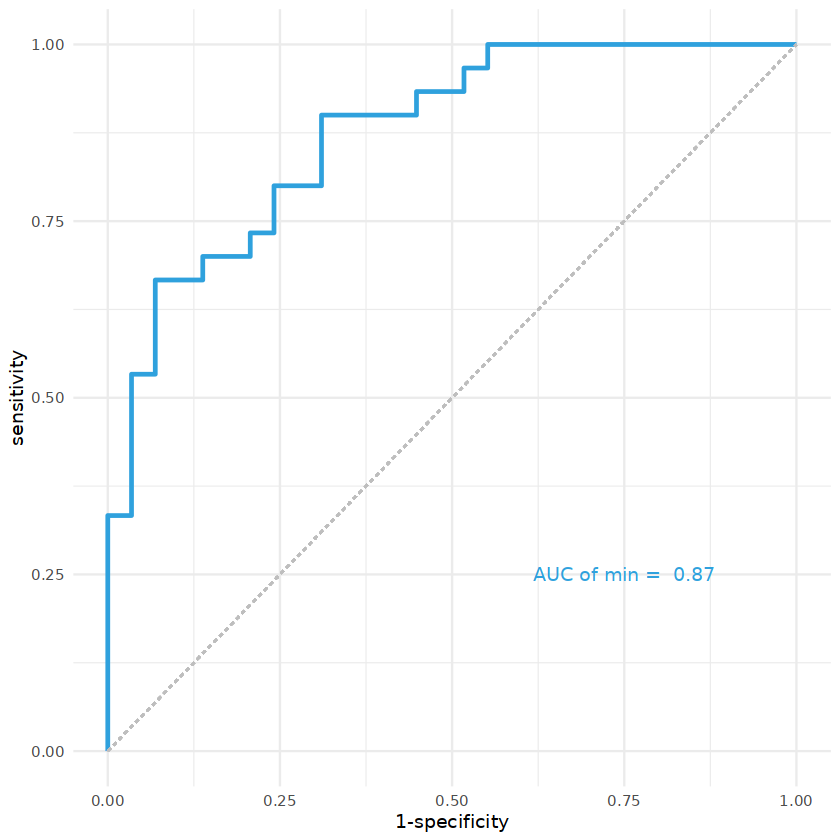

In [237]:
g <- pROC::ggroc(m,legacy.axes = T,size = 1,color = "#2fa1dd")
pROC::auc(m)  # Area under the curve: 0.9953

g + theme_minimal() +
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), 
               colour = "grey", linetype = "dashed")+
  annotate("text",x = .75, y = .25,
           label = paste("AUC of min = ",format(round(as.numeric(pROC::auc(m)),2),nsmall = 2)),color = "#2fa1dd")

In [238]:
library(ROCR)

In [239]:
dd<-datadist(data)  #开始打包数据
options(datadist="dd")

In [250]:
data$Group = as.factor(data$Group)

In [251]:
fit1 <- lrm(Group~RPE65 + DRD3+ MC3R+RELB  + PRF1, data=data,x=T,y=T)


In [252]:
fit1

Logistic Regression Model

lrm(formula = Group ~ RPE65 + DRD3 + MC3R + RELB + PRF1, data = data, 
    x = T, y = T)

                       Model Likelihood     Discrimination    Rank Discrim.    
                             Ratio Test            Indexes          Indexes    
Obs            59    LR chi2      30.80     R2       0.542    C       0.875    
 0             29    d.f.             5     R2(5,59) 0.354    Dxy     0.749    
 1             30    Pr(> chi2) <0.0001    R2(5,44.2)0.442    gamma   0.749    
max |deriv| 3e-09                           Brier    0.146    tau-a   0.381    

          Coef    S.E.   Wald Z Pr(>|Z|)
Intercept  9.1037 4.5460  2.00  0.0452  
RPE65     -1.4752 0.5688 -2.59  0.0095  
DRD3      -1.0804 0.5528 -1.95  0.0507  
MC3R      -1.2752 0.5846 -2.18  0.0291  
RELB      -0.1619 0.7859 -0.21  0.8367  
PRF1      -0.7167 0.4253 -1.69  0.0920  


In [253]:
#  https://blog.csdn.net/Ayue0616/article/details/126601832


Divergence or singularity in 6 samples

n=59   Mean absolute error=0.056   Mean squared error=0.00352
0.9 Quantile of absolute error=0.078



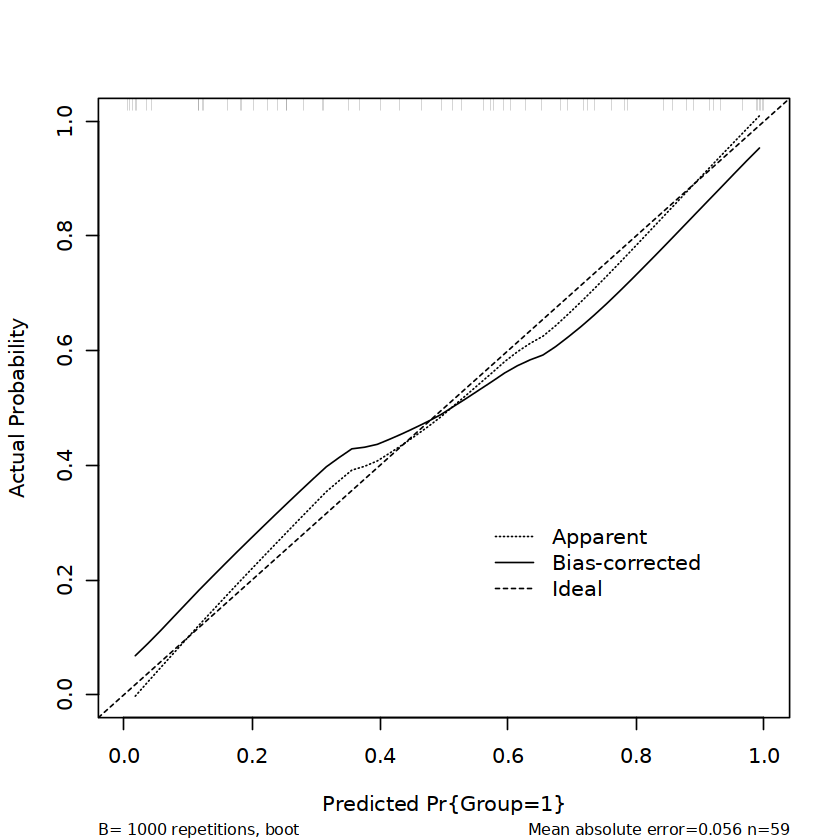

In [254]:
cal1 <- calibrate(fit1, method='boot', B=1000) 
plot(cal1,xlim=c(0,1.0),ylim=c(0,1.0))

In [255]:
fit1

Logistic Regression Model

lrm(formula = Group ~ RPE65 + DRD3 + MC3R + RELB + PRF1, data = data, 
    x = T, y = T)

                       Model Likelihood     Discrimination    Rank Discrim.    
                             Ratio Test            Indexes          Indexes    
Obs            59    LR chi2      30.80     R2       0.542    C       0.875    
 0             29    d.f.             5     R2(5,59) 0.354    Dxy     0.749    
 1             30    Pr(> chi2) <0.0001    R2(5,44.2)0.442    gamma   0.749    
max |deriv| 3e-09                           Brier    0.146    tau-a   0.381    

          Coef    S.E.   Wald Z Pr(>|Z|)
Intercept  9.1037 4.5460  2.00  0.0452  
RPE65     -1.4752 0.5688 -2.59  0.0095  
DRD3      -1.0804 0.5528 -1.95  0.0507  
MC3R      -1.2752 0.5846 -2.18  0.0291  
RELB      -0.1619 0.7859 -0.21  0.8367  
PRF1      -0.7167 0.4253 -1.69  0.0920  


In [261]:
save(fit1,data,file = 'bulk2.fit1.rda')

In [ ]:
#列线图代码只能在Rstudio话

In [263]:
# library('regplot')
# regplot(fit1,
#         plots = c("violin", "boxes"), ##连续性变量形状，可选"no plot" "density" "boxes" "ecdf" "bars" "boxplot" "violin" "bean" "spikes"；分类变量的形状，可选"no plot" "boxes" "bars" "spikes"
#         observation = data[1,], #用哪行观测，或者T F
#         center = T, # 对齐变量
#         subticks = T,
#         droplines = T,#是否画竖线
#         title = "nomogram",
#         points = T, # 截距项显示为0-100
#         odds = T, # 是否显示OR值
#         showP = T, # 是否显示变量的显著性标记
#         rank = "sd", # 根据sd给变量排序
#         interval="confidence", # 展示可信区间
#         clickable = F # 是否可以交互
# )

In [271]:
fit.result<-summary(fit.reduce)
df1<-fit.result$coefficients
df2<-confint(fit.reduce)
df3<-cbind(df1,df2)
df4<-data.frame(df3[-1,c(1,4,5,6)])
df4$Var<-rownames(df4)
colnames(df4)<-c("OR","Pvalue","OR_1","OR_2","Var")
df5<-df4[,c(5,1,2,3,4)]
df5$OR_mean<-df5$OR
df5$OR<-paste0(round(df5$OR,2),
               "(",
               round(df5$OR_1,2),
               "~",
               round(df5$OR_2,2),
               ")")
df5$Pvalue<-round(df5$Pvalue,3)
write.csv(df5,file = "forestplot_example.csv",
          quote = F,row.names = F)

Waiting for profiling to be done...



In [280]:
fp

Var,OR,Pvalue,OR_1,OR_2,OR_mean
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
RPE65,-1.48(-2.74~-0.49),0.009,-2.744777,-0.49300235,-1.4752034
MC3R,-1.28(-2.55~-0.2),0.029,-2.546081,-0.19960417,-1.2752207
DRD3,-1.08(-2.26~-0.06),0.051,-2.262772,-0.05623621,-1.0803619
RELB,-0.16(-1.82~1.34),0.837,-1.820259,1.33580803,-0.1619486
PRF1,-0.72(-1.63~0.07),0.092,-1.628295,0.07071986,-0.7166910


Loading required package: checkmate

Warning message:
"package 'checkmate' was built under R version 4.2.3"

Attaching package: 'checkmate'


The following object is masked from 'package:Biobase':

    anyMissing


Loading required package: abind

Warning message:
"package 'abind' was built under R version 4.2.3"


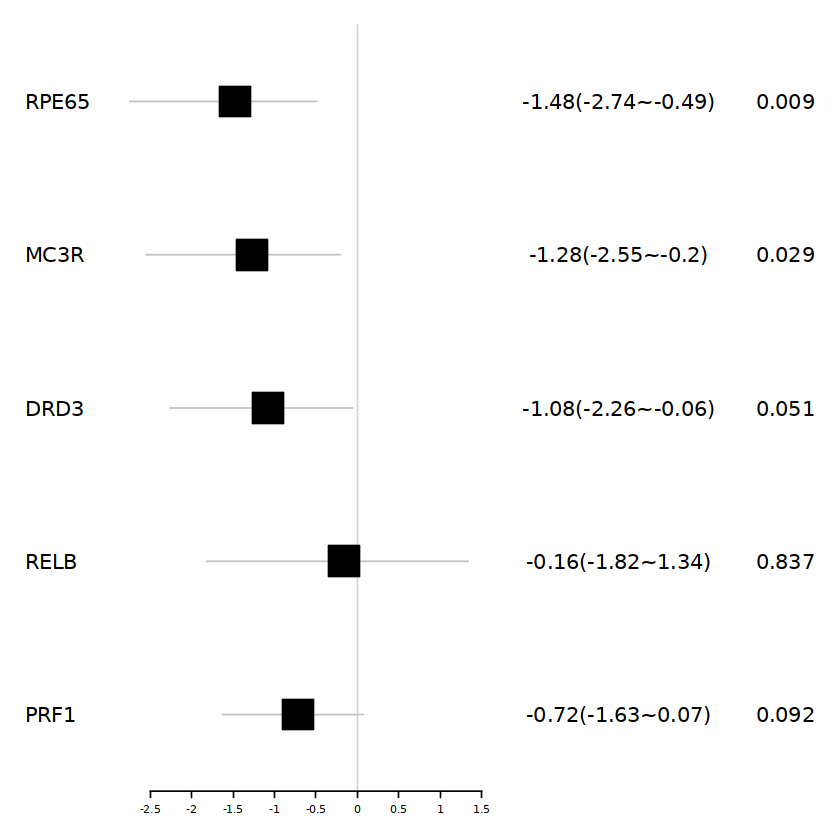

In [273]:
library(forestplot)
fp<-read.csv("forestplot_example.csv",header=T)

forestplot(labeltext=as.matrix(fp[,1:3]),
           mean=fp$OR_mean,
           lower=fp$OR_1,
           upper=fp$OR_2,
           zero=0,
           boxsize=0.2,
           graph.pos=2)

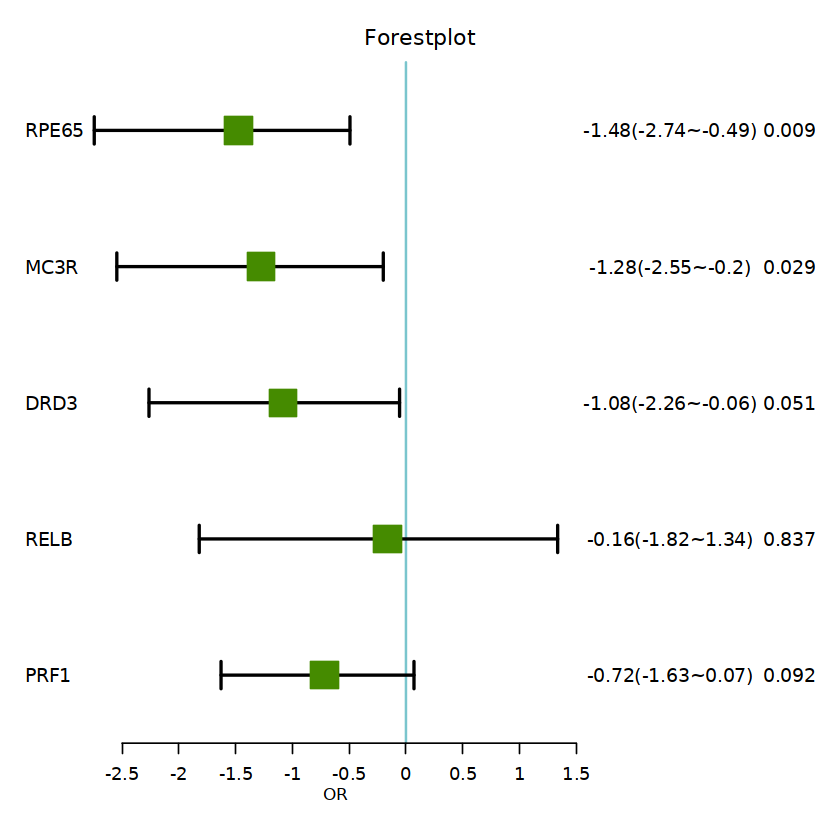

In [274]:
forestplot(labeltext=as.matrix(fp[,1:3]),
           mean=fp$OR_mean,
           lower=fp$OR_1,
           upper=fp$OR_2,
           zero=0,
           boxsize=0.2,
           lineheight = unit(7,'mm'),
           colgap=unit(2,'mm'),
           lwd.zero=1.5,
           lwd.ci=2, 
           col=fpColors(box='#458B00',
                        summary='#8B008B',
                        lines = 'black',
                        zero = '#7AC5CD'),
           xlab="OR",
           lwd.xaxis =1,
           txt_gp = fpTxtGp(ticks = gpar(cex = 0.85),
                            xlab  = gpar(cex = 0.8),
                            cex = 0.9),
           lty.ci = "solid",
           title = "Forestplot", 
           line.margin = 0.08,
           graph.pos=2)


In [209]:
nmfinput= data[MDD,c('RPE65' ,'DRD3','MC3R','RELB' , 'PRF1')] %>%  t() %>%  as.data.frame()

In [210]:
library(NMF)

In [211]:
ranks <- 1:10
estim.coad <- nmf(nmfinput,ranks, nrun=10)
duplicated(colnames(nmfinput))

Warning message in cor(d.consensus, d.coph, method = "pearson"):
"the standard deviation is zero"


[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE

Warning message:
"Removed 3 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 11 rows containing missing values (`geom_point()`)."


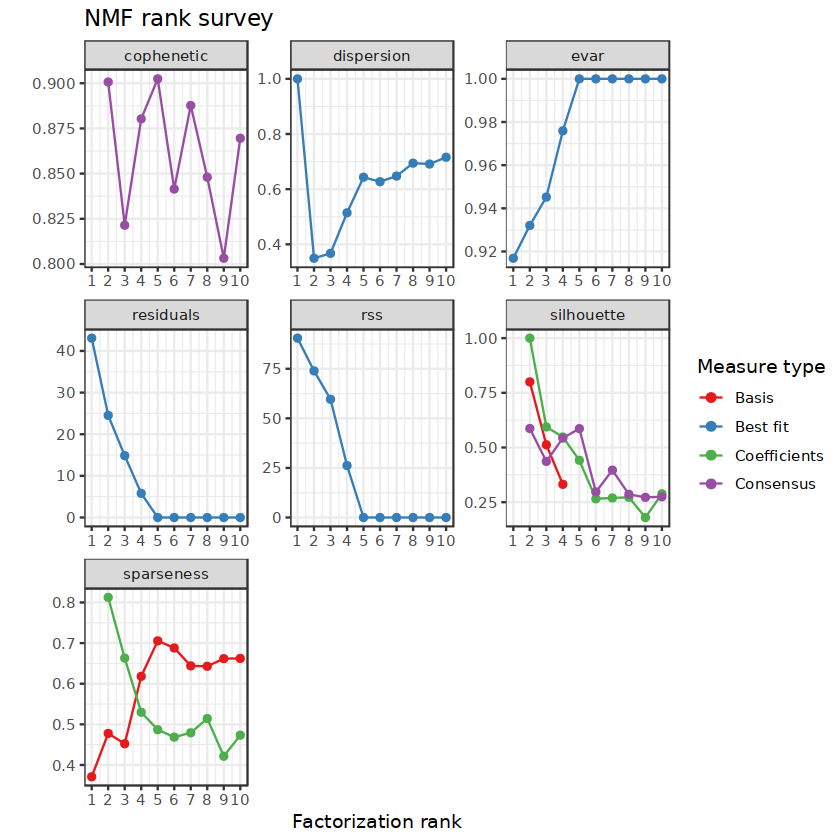

In [212]:
plot(estim.coad)

In [213]:
seed = 2020820
nmf.rank4 <- nmf(nmfinput, 
                 rank = 2, 
                 nrun=50,
                 seed = seed, 
                 method = "brunet")

group
 1  2 
21  9 

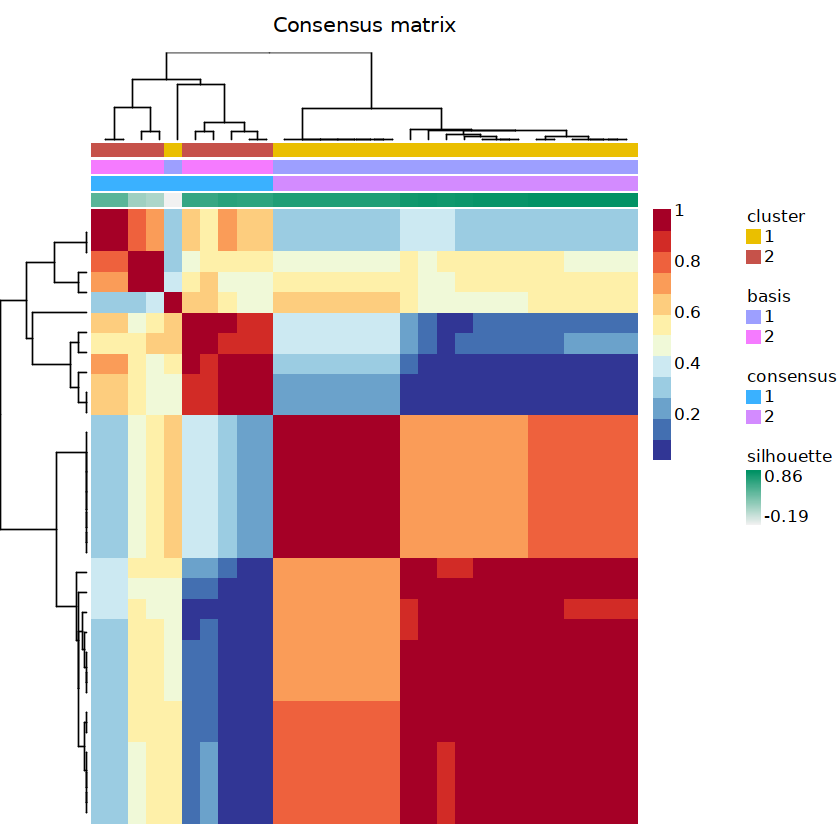

In [214]:
jco <- c("#EABF00","#C6524A","#868686")
index <- extractFeatures(nmf.rank4,"max") 
sig.order <- unlist(index)
NMF.Exp.rank4 <- nmfinput[sig.order,]
NMF.Exp.rank4 <- na.omit(NMF.Exp.rank4) #sig.order有时候会有缺失值
group <- predict(nmf.rank4) # 提出亚型
table(group)
consensusmap(nmf.rank4,
             labRow = NA,
             labCol = NA,
             annCol = data.frame("cluster"=group[colnames(NMF.Exp.rank4)]),
             annColors = list(cluster=c("1"=jco[1],"2"=jco[2])))

In [215]:
library(tinyarray)

In [225]:
data1 = data[MDD,-1] %>%  t() %>% as.data.frame()

In [226]:
a = data1[,colnames(nmfinput)]

In [227]:
cg=names(tail(sort(apply(a,1,sd)),12000))
n=a[cg,]

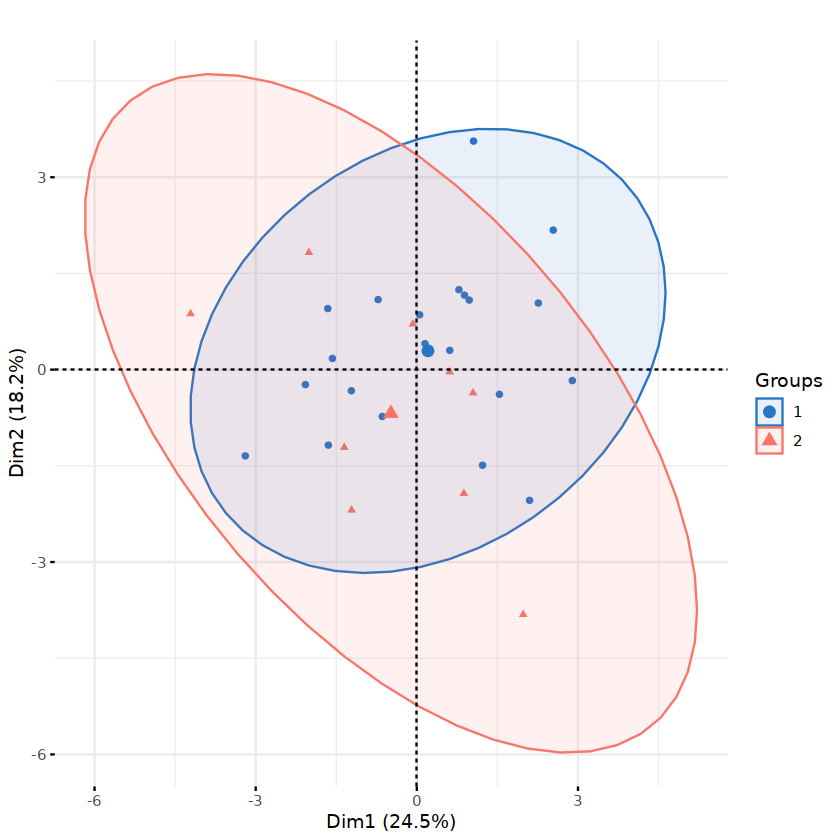

In [228]:
draw_pca(n,group)

In [231]:
library(Rtsne)
tsne_out = Rtsne(t(n),perplexity = 1)
pdat = data.frame(tsne_out$Y,factor(group))
colnames(pdat) = c("Y1","Y2","group")
head(pdat)

,Y1,Y2,group
,<dbl>,<dbl>,<fct>
V10,49.59959,172.010281,2
V15,207.23713,-79.947753,2
V16,201.56723,-89.036425,1
V18,-43.43508,3.824127,2
V19,-185.23555,98.308446,1
V20,-37.09595,-82.671437,1


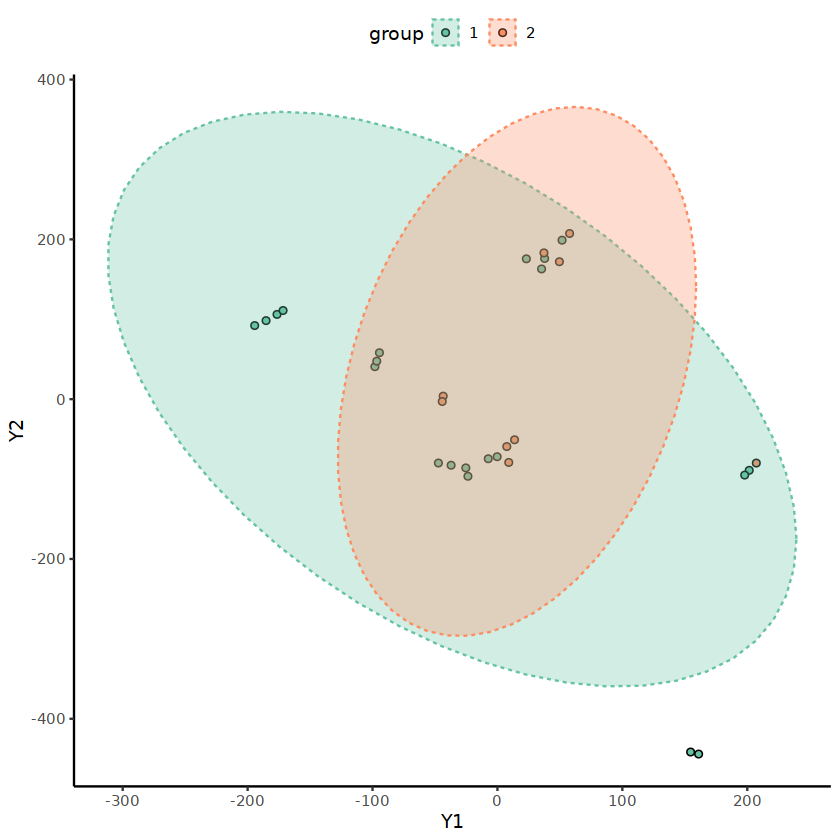

In [232]:
library(ggplot2)
library(paletteer)
ggplot(pdat,aes(Y1,Y2))+
  geom_point(aes(Y1,Y2,fill = group),shape = 21,color = "black")+
  stat_ellipse(aes(color = group,fill = group),
               geom = "polygon",
               alpha = 0.3,
               linetype = 2)+
  scale_color_paletteer_d("RColorBrewer::Set2")+
  scale_fill_paletteer_d("RColorBrewer::Set2")+
  theme_classic()+
  theme(legend.position = "top")